# **Wine Quality Classification**
---
**Processed by: Guy Kahana & Anat Peled**

Source: [Wine-quality](https://www.kaggle.com/rajyellow46/wine-quality)

Acknowledgements: 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. *Modeling wine preferences by data mining from physicochemical properties*. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

PDF presentaion is available here: [Presentation](https://github.com/pelanat1207/Project_4-Wine-Quality/blob/main/wine_quality_pdf.pdf)

> This project is the 4th assignment required in *Data Science Course, Naya College* and submitted to the instructor Dror Geva.
> The project main purpose was to explore and practice the ML classification processes along with advanced technicques of fearures selections, grid search, validation methods and demonstrate deep understanding of score method selection. 


The purpose of this data set is to predict the quality of a wine based on its chemical features. 

In [ ]:
# General tools
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image, HTML
from plotnine import *
import pydot
import math
import warnings
import time
warnings.filterwarnings("ignore")

# For transformations and predictions
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

# For scoring
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import make_scorer

# For validation
from sklearn.model_selection import train_test_split as split

sns.set(style='whitegrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## **Import the data**

In [ ]:
path = '../input/wine-quality/winequalityN.csv'
df = pd.read_csv(path)

# **At first glance...**
---

In [ ]:
# Showing 5 first lines of the data
df.head()

In [ ]:
df.info()

In [ ]:
numeric_columns = df.columns[df.dtypes != 'object']
string_columns = df.columns[df.dtypes == 'object']
print(f'There are {len(numeric_columns)} numeric columns & {len(string_columns)} string columns')

Looking at linear correlation among numerical features as a heatmap, reveals small to medium correlation between different features.

As for the correlation to our target - the highest correlation is to alcohol with 0.44.

In [ ]:
# Numeric Heatmap
numeric_df = pd.DataFrame(data=df, columns=numeric_columns, index=df.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sns.color_palette("rainbow")
sns.heatmap(corr, cmap=cmap, square=True)
plt.title('Correlation between numerical features: abs values')
plt.show()

In [ ]:
series = np.abs(corr['quality']).sort_values(ascending=False)
print('The most linear correlated features to QUALITY are:')
for i, row in enumerate(series):
    if 0.2 <= row < 1:
      print(f'{series.index[i]:17} --> {row: .2f} (abs)')

Pairplot representation of the data with differentiation between the only categorical feature, the wine type, reveals some intresting observations regarding the correlation of features of each type. 

It can also be seen quite easily that almost most of the features have one or more suspected outliers.

Therefore, for each feature we will explore the wine type differntiation and outliers detection.

In [ ]:
# Seaborn pairplot
sns_plot = sns.pairplot(df, hue='type', height=3)
plt.show()

## **Duplicates**

Looking for duplicates in the dataset, reveals 1168 records marked as duplicates, almost 20% of the data.
The [original](https://archive.ics.uci.edu/ml/datasets/wine+quality) introduction of this dataset has 4898 records. Our Kaggle dataset contains 6497 records. 

The duplicates can not explain the gap between the copies of the dataset. Since the duplicates contain red & white wine with 3:1 ratio we believe that along the way someone added sampling data to the original dataset, and hence the dulicates. 

We have decided to keep the duplicates, since part of the challenge in this project is to deal with imbalanced data, and the current setting of the data support this purpose.

In [ ]:
df.duplicated().sum()

In [ ]:
df['type'].loc[df.duplicated()==1].value_counts()

# **EDA**
---

## **Type**

This is the single categorical feature in the dataset, except for the target. There are two types of wines - red wine and white wine.

* There are no null values 

* The two type of wine are divided 75%-25% (white/red)

In [ ]:
df.groupby('type')['quality'].count().to_frame()

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
pd.options.display.float_format = '{:,.2f}'.format

bar_chart = df.groupby(['type','quality'])['quality'].count().unstack('type')
bar_chart= (bar_chart.T/bar_chart.T.sum()).T
ax = bar_chart.plot(kind='bar', stacked=True, color=['r','w'], edgecolor='black', ax=ax)

labels = []
for j in bar_chart.columns:
    for i in bar_chart.index:
          label = str('{0:.2%}'.format(bar_chart.loc[i][j]))
          labels.append(label)

patches = ax.patches

for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center', color='black')

ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(labels='')
ax.set_ylabel('% of records')
plt.legend(bbox_to_anchor = (1, 1.01), edgecolor='black')
plt.show()

In [ ]:
data = df.groupby('type')['quality'].count()
fig, ax = plt.subplots(figsize=[10,6])
labels = ['red','white']
ax = plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*2, labels=labels, colors=['darkred','white'],
             wedgeprops={"edgecolor":"black"},pctdistance=0.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))
ax = sns.violinplot(data=df ,x=df.type ,y=df.quality)

ax.set_ylabel('Quality', fontsize=14)
plt.tight_layout()

## **Fixed acidity**

Wines with higher acidity feel lighter-bodied because they come across as “spritzy”. Reducing acids significantly might lead to wines tasting flat. If you prefer a wine that is richer and rounder, you enjoy slightly less acidity.

 * 10 null values will later be filled with average
 * It seems like very high\low fixed acidity represent very poor or very good quality
 * Values between 3.8 and 15.9: feature will need scaling

In [ ]:
df['fixed acidity'].isnull().sum()

In [ ]:
df['fixed acidity'].describe()

In [ ]:
colors = ['r']
sns.set_palette(sns.color_palette(colors))
df['fixed acidity'].hist(bins=40)
plt.show()

In [ ]:
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
data =  df.groupby(['quality','type'])['fixed acidity'].mean().reset_index()
s = df.groupby(['quality','type'])['fixed acidity'].count().reset_index()
data = pd.concat([data, s['fixed acidity']], axis=1)
data.columns = ['quality', 'type', 'fixed acidity', 'size']
ax = sns.scatterplot(x='quality', y='fixed acidity', hue='type', cmap=colors, data=data, size='size', sizes=(100,1000), legend='brief')
ax.legend(bbox_to_anchor=(1.12,1), markerscale=0.4, facecolor ='lightgrey')
ax.set_title('')
ax.set_facecolor('black')
ax.set_ylabel('Mean fixed acidity', fontsize=12)
plt.tight_layout()

## **Volatile acidity**

> Excess of volatile acids are undesirable and lead to unpleasant flavour.

In [ ]:
df['volatile acidity'].isnull().sum()

In [ ]:
df['volatile acidity'].describe()

In [ ]:
colors = ['r']
df['volatile acidity'].hist(bins=40)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
ax.set_facecolor('lightgrey')
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=df,y='volatile acidity',x='quality',hue='type')
plt.show()

* Red wine volatile acidity is higher than white wines and tends to descent with quality
* Mean white wines fixed acidity is almost linear
* 8 null values
* Outliers detected
* Correlation to quality --> 0.27 (abs)

## **Citric acid**

This is one of the fixed acids which gives a wine its freshness. Usually most of it is consumed during the fermentation process and sometimes it is added separately to give the wine more freshness.

In [ ]:
df['citric acid'].isnull().sum()

In [ ]:
df['citric acid'].describe()

In [ ]:
colors = ['r']
sns.set_palette(sns.color_palette(colors))
df['citric acid'].hist(bins=40)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
ax.set_facecolor('lightgrey')
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=df,y='citric acid',x='quality',hue='type')
plt.show()

In [ ]:
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
data =  df.groupby(['quality','type'])['citric acid'].mean().reset_index()
s = df.groupby(['quality','type'])['citric acid'].count().reset_index()
data = pd.concat([data, s['citric acid']], axis=1)
data.columns = ['quality', 'type', 'citric acid', 'size']
ax = sns.scatterplot(x='quality', y='citric acid', hue='type', cmap=colors, data=data, size='size', sizes=(100,1000), legend='brief')
ax.legend(bbox_to_anchor=(1.12,1), markerscale=0.4, facecolor ='lightgrey')
ax.set_title('')
ax.set_facecolor('black')
ax.set_ylabel('Mean citric acid', fontsize=12)
plt.tight_layout()

* At quality levels <5 - mean citric acid levels are relatively different
* 3 null values
* Outlier detected

## **Residual sugar**

This typically refers to the natural sugar from grapes which remains after the fermentation process is stopped.
* 2 Null values
* Outliers detected

In [ ]:
df['residual sugar'].isnull().sum()

In [ ]:
df['residual sugar'].describe()

In [ ]:
colors = ['r']
sns.set_palette(sns.color_palette(colors))
df['residual sugar'].hist(bins=30)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
ax.set_facecolor('lightgrey')
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=df[df['residual sugar']<40],y='residual sugar',x='quality',hue='type')
plt.show()

## **Chlorides**

Chloride concentration in the wine is influenced by terroir and its highest levels are found in wines coming from countries where irrigation is carried out using salty water or in areas with brackish terrains.

In [ ]:
df['chlorides'].isnull().sum()

In [ ]:
df['chlorides'].describe()

In [ ]:
colors = ['r']
sns.set_palette(sns.color_palette(colors))
df['chlorides'].hist(bins=30)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
ax.set_facecolor('lightgrey')
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=df,y='chlorides',x='quality',hue='type')
plt.show()

In [ ]:
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
data =  df.groupby(['quality','type'])['chlorides'].mean().reset_index()
s = df.groupby(['quality','type'])['chlorides'].count().reset_index()
data = pd.concat([data, s['chlorides']], axis=1)
data.columns = ['quality', 'type', 'chlorides', 'size']
ax = sns.scatterplot(x='quality', y='chlorides', hue='type', cmap=colors, data=data, size='size', sizes=(100,1000), legend='brief')
ax.legend(bbox_to_anchor=(1.12,1), markerscale=0.4, facecolor ='lightgrey')
ax.set_title('')
ax.set_facecolor('black')
ax.set_ylabel('Mean chlorides', fontsize=12)
plt.tight_layout()

* Mean chloride level decline with quality increase
* Red Wines have higher chloride levels than white wines
* 2 nulls
* Outliers detected

## **Free Sulfur Dioxide (FSD)**

This is the part of the sulphur dioxide that when added to a wine is said to be free after the remaining part binds. Winemakers will always try to get the highest proportion of free sulphur to bind. They are also known as sulfites and too much of it is undesirable and gives a pungent odour. 

In [ ]:
df['free sulfur dioxide'].isnull().sum()

In [ ]:
df['free sulfur dioxide'].describe()

In [ ]:
# Looking at the outlier
df.loc[df['free sulfur dioxide']>150]

In [ ]:
# Histogram without the outlier
FSD = df.loc[df['free sulfur dioxide']<150]
plt.hist(FSD['free sulfur dioxide'], bins=20, color='r')
plt.xlabel('FSD level')
plt.ylabel('# of records')
plt.show()

In [ ]:
# Creating the canvas & colors
fig, ax = plt.subplots(figsize=(15, 5))
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))
ax.set_facecolor('lightgrey')

# data
ax = sns.boxplot(data=FSD, x='quality', y='free sulfur dioxide', hue='type')
ax.set_title('Free SO2 levels vs. quality category')
ax.set_ylabel('Free SO2')
ax.set_xlabel('Quality')
plt.show()

In [ ]:
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
data =  df.groupby(['quality','type'])['free sulfur dioxide'].mean().reset_index()
s = df.groupby(['quality','type'])['free sulfur dioxide'].count().reset_index()
data = pd.concat([data, s['free sulfur dioxide']], axis=1)
data.columns = ['quality', 'type', 'free sulfur dioxide', 'size']
ax = sns.scatterplot(x='quality', y='free sulfur dioxide', hue='type', cmap=colors, data=data, size='size', sizes=(100,1000), legend='brief')
ax.legend(bbox_to_anchor=(1.12,1), markerscale=0.4, facecolor ='lightgrey')
ax.set_title('')
ax.set_facecolor('black')
ax.set_ylabel('Mean free sulfur dioxide', fontsize=12)
plt.tight_layout()

* Red wines have lower free sulfor dioxide conc. at the same quality level
* Red wines do not exceed FSD conc. > 80 in this dataset
* White wines has higher free SO2 levels
* Mean level of SO2 in white wines with quality = 4 is showing anomalous
* No null values
* Min = 1, Max = 289, Mean = 30.52
* 1 outlier detected with FDS=289, quality is 3 (the lowest).

## **Total Sulfur Dioxide (TSD)**

This is the sum total of the bound and the free sulfur dioxide. This is mainly added to kill harmful bacteria and preserve quality and freshness. There are usually legal limits for sulfur levels in wines and excess of it can even kill good yeast and give out undesirable odour.

In [ ]:
df['total sulfur dioxide'].isnull().sum()

In [ ]:
df['total sulfur dioxide'].describe()

In [ ]:
plt.hist(df['total sulfur dioxide'], bins=40)
plt.xlabel('Total SO2')
plt.ylabel('# of records')
plt.show()

Examining the high values (above 325) of total sulfur dioxide reveals that one point (id 4745) is the outlier from FSD section with 440 level. 

In [ ]:
df.loc[df['total sulfur dioxide']>325,:]

In [ ]:
# Creating the canvas & colors
fig, ax = plt.subplots(figsize=(15, 5))
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))
ax.set_facecolor('lightgrey')

# Data
ax = sns.boxplot(data=df, x='quality', y='total sulfur dioxide', hue='type')
ax.set_ylabel('Total SO2')
ax.set_xlabel('Quality')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_facecolor('darkgrey')
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))

ax = sns.lineplot(x='quality',
                  y='total sulfur dioxide',
                  hue='type', 
                  data = df.groupby(['quality','type'])['total sulfur dioxide'].mean().reset_index())
ax.set_ylabel('Mean total sulfur dioxide')
plt.show()

* Total mean SO2 levels are higher in white wines than in red wines, but remain relatively constant among quality groups.
* No null values
* min = 6, max = 440, mean = 115

## **Density**

This can be represented as a comparison of the weight of a specific volume of wine to an equivalent volume of water. It is generally used as a measure of the conversion of sugar to alcohol. Usually, wine has higher density from water by 8-9%.

In [ ]:
df.density.isnull().sum()

In [ ]:
df.density.describe()

Density values are actually densed and varied between 0.987 and 1.03. 

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_facecolor('darkgrey')
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))

sns.boxplot(data=df[df['density']<1.03], y='density', x='quality', hue='type')
plt.show()

Looking closely at suspected outliers reveals 3 records: 2 of them are identical, and one distinguished.

In [ ]:
df.loc[df.density>=1.005,:]

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_facecolor('darkgrey')
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))

ax = sns.lineplot(x='quality',
                  y='density',
                  hue='type', 
                  data = df.groupby(['quality','type'])['density'].mean().reset_index())
ax.set_ylabel('Mean density')
plt.show()

Mean density values decline as quality increase in both types of wines.

## **pH**

Also known as the potential of hydrogen, this is a numeric scale to specify the acidity or basicity the wine. Fixed acidity contributes the most towards the pH of wines. You might know, solutions with a pH less than 7 are acidic, while solutions with a pH greater than 7 are basic. With a pH of 7, pure water is neutral. Most wines have a pH between 2.9 and 3.9 and are therefore acidic.

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_facecolor('darkgrey')
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))

sns.boxplot(data=df, y='pH', x='quality', hue='type')
plt.show()

In [ ]:
# Null values
df.loc[df['pH'].isnull() == 1, :]

In [ ]:
df['pH'].loc[df['type']=='red'].mean()

In [ ]:
df['pH'].loc[df['type']=='white'].mean()

In [ ]:
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
data =  df.groupby(['quality','type'])['pH'].mean().reset_index()
s = df.groupby(['quality','type'])['pH'].count().reset_index()
data = pd.concat([data, s['pH']], axis=1)
data.columns = ['quality', 'type', 'pH', 'size']
ax = sns.scatterplot(x='quality', y='pH', hue='type', cmap=colors, data=data, size='size', sizes=(100,1000), legend='brief')
ax.legend(bbox_to_anchor=(1.12,1), markerscale=0.4, facecolor ='lightgrey')
ax.set_title('')
ax.set_facecolor('black')
ax.set_ylabel('Mean pH', fontsize=12)
plt.tight_layout()

There is a difference with pH 'behaviour' between red and white wines.

The average pH is not the same for white and red wines. Later, We will use an imputer to replace NaN values with the mean values according to the type.

## **Sulphates**

These are mineral salts containing sulfur. They are a regular part of the winemaking around the world and are considered essential. They are connected to the fermentation process and affects the wine aroma and flavour.

In [ ]:
# Looking at null values
df.loc[df.sulphates.isnull()==1]

In [ ]:
df['sulphates'].loc[df['type']=='white'].mean()

In [ ]:
df['sulphates'].loc[df['type']=='red'].mean()

The average sulphates level vary in white and red wines. We will use simple imputer to replace NaN values with the mean values according to the type.

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_facecolor('darkgrey')
colors = ['w', 'r']
sns.set_palette(sns.color_palette(colors))
sns.stripplot(data=df, y='sulphates', x='quality', hue='type', alpha=0.5, orient='v')
plt.show()

Red wines have higher sulphates values than white wines.


In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_facecolor('darkgrey')
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
ax = sns.lineplot(x='quality',
                  y='sulphates',
                  hue='type', 
                  data = df.groupby(['quality','type'])['sulphates'].mean().reset_index())
ax.set_ylabel('Mean sulphates')
plt.show()

## **Alcohol**

It's usually measured in % vol or alcohol by volume (ABV)

In [ ]:
df.alcohol.describe()

In [ ]:
sns.distplot(df.alcohol, bins=20, kde=True)
ax.set_title('Histogram')
ax.set_xlabel('% Alcohol')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_facecolor('darkgrey')
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
ax = sns.lineplot(x='quality',
                  y='alcohol',
                  hue='type', 
                  data = df.groupby(['quality','type'])['alcohol'].mean().reset_index())
ax.set_ylabel('Mean alcohol')
plt.show()

This feature doesn't demonsrate a difference between white and red wines.

Higher mean alcohol volumes are associated with higher quality.

## **Quality: The Target**

Wine experts graded the wine quality between 0 (very bad) and 10 (very excellent). The eventual quality score is the median of at least three evaluations made by the same wine experts. De facto values begin at 3, and ends at 8 or 9 (red and white wines respectively).

In [ ]:
rw = df.loc[df['type']=='red'].quality.describe()
ww = df.loc[df['type']=='white'].quality.describe()
data = pd.DataFrame(data=[rw,ww], index=['Red Wines', 'White Wines'])
data

In [ ]:
rw = df.loc[df['type']=='red'].quality.value_counts(normalize=True).sort_index()
ww = df.loc[df['type']=='white'].quality.value_counts(normalize=True).sort_index()
data = pd.DataFrame(data=[rw,ww], index=['Red Wines', 'White Wines'])
data

In [ ]:
# Quality = 9 --> 5 records
df.loc[df.quality==9]

## **Feature Engineering**

### **Sulfur dioxide ratio**

Since free sulfur dioxide is the unbound part of total sulfur dioxide, we will caculate the ratio of this two features.
This feature has higher correlation to quality than each of the individuals 

In [ ]:
df['sulfur dioxide ratio'] = df['free sulfur dioxide']/df['total sulfur dioxide']

In [ ]:
numeric_columns=['free sulfur dioxide','total sulfur dioxide','sulfur dioxide ratio','quality']
numeric_df = pd.DataFrame(data=df, columns=numeric_columns, index=df.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.color_palette("rainbow")
sns.heatmap(corr, cmap=cmap, square=True, annot=True)
plt.title('Correlation between numerical features: abs values')
plt.show()

In [ ]:
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
data =  df.groupby(['quality','type'])['sulfur dioxide ratio'].mean().reset_index()
s = df.groupby(['quality','type'])['sulfur dioxide ratio'].count().reset_index()
data = pd.concat([data, s['sulfur dioxide ratio']], axis=1)
data.columns = ['quality', 'type', 'sulfur dioxide ratio', 'size']
ax = sns.scatterplot(x='quality', y='sulfur dioxide ratio', hue='type', cmap=colors, data=data, size='size', sizes=(100,1000), legend='brief')
ax.legend(bbox_to_anchor=(1.12,1), markerscale=0.4, facecolor ='lightgrey')
ax.set_title('')
ax.set_facecolor('black')
ax.set_ylabel('Mean sulfur dioxide ratio', fontsize=12)
plt.tight_layout()

### **Acidity factor**

Looking at citric acid feature, there isn't a clear sepration between red and white wines. We decided to multiply the 3 acid features to create a new feature which demonstrates a differntiation between red and white wines.


In [ ]:
df['acidity factor'] = df['fixed acidity']*df['volatile acidity']*df['citric acid']

In [ ]:
numeric_columns=['fixed acidity','volatile acidity','citric acid','acidity factor','quality']
numeric_df = pd.DataFrame(data=df, columns=numeric_columns, index=df.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.color_palette("rainbow")
sns.heatmap(corr, cmap=cmap, square=True, annot=True)
plt.title('Correlation between numerical features:\n abs values')
plt.show()

In [ ]:
colors = ['r']
sns.set_palette(sns.color_palette(colors))
df['acidity factor'].hist(bins=40)
plt.show()

In [ ]:
colors = ['r', 'w']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(1, figsize=(12, 5), sharey=True, sharex = True)
data =  df.groupby(['quality','type'])['acidity factor'].mean().reset_index()
s = df.groupby(['quality','type'])['acidity factor'].count().reset_index()
data = pd.concat([data, s['acidity factor']], axis=1)
data.columns = ['quality', 'type', 'acidity factor', 'size']
ax = sns.scatterplot(x='quality', y='acidity factor', hue='type', cmap=colors, data=data, size='size', sizes=(100,1000), legend='brief')
ax.legend(bbox_to_anchor=(1.12,1), markerscale=0.4, facecolor ='lightgrey')
ax.set_title('')
ax.set_facecolor('black')
ax.set_ylabel('Mean acidity factor', fontsize=12)
plt.tight_layout()

# **Data Insights**

* Most features show different behavior regarding the wine type, but the type by itself can’t predict the quality. 
* Should we predict the wine type, one could expect high prediction rates. 
* Quality prediction rate is expected to be low, due to imbalanced dataset
* The ability to predict categories 3, 4, 8 & 9 is expected to be very low due to small sample size 
* Imputing nulls must take into consideration the wine type
* Outliers removals is essential in almost 50% of features
* Scaling is required due to different values scale (<1, 10s, 100s)
* The engineered features were aimed to unite similar indicative feature to a more solid feature. But while in sulfur we decided to drop the original features, at acidity we will use it all.
* We suspect that applying different prediction models on white and red wines may get higher prediction score.


# **Pre-Processing**

First, we will create a clean copy of the data

In [ ]:
df = pd.read_csv(path)

## **Outliers**

We define a function that removes outliers according to a preset dictionary.

In [ ]:
def limit_value(X, **val_dict):
  """This function recieves a dataframe and returns
     it without the outliers
  """
  for col, val in val_dict.items():
      X = X.loc[X[col] < val, :]
  return X

In [ ]:
# Dictionary of outliers
outlier_dict = {'free sulfur dioxide': 150,
                'total sulfur dioxide': 400,
                'density': 1.01,
                'sulphates': 1.75,
                'volatile acidity':1.5,
                'citric acid': 1.2,
                'residual sugar': 50,
                'chlorides': 0.5}

# Clean outliers
outlier_limit = FunctionTransformer(limit_value, kw_args = outlier_dict)
df = outlier_limit.transform(df)

## **Feature Engineering**

We create the 2 new features and replace the type with [0,1].

In [ ]:
def feature_engineering(X):
  """This function creates two new features
  """
  X['sulfur dioxide ratio'] = X['free sulfur dioxide']/X['total sulfur dioxide']
  X['acidity factor'] = X['fixed acidity']**0.7 * X['volatile acidity']*0.55 * X['citric acid']*50
  X['type'] = np.where(X['type']=='red', 0, 1)
  return X

In [ ]:
fe = FunctionTransformer(feature_engineering)
df = fe.transform(df)

## **Select Features**

We drop the 2 original sulfur features since it is replaced by its ratio.

In [ ]:
col_to_drop = ['free sulfur dioxide', 'total sulfur dioxide']
df = df.drop(labels=col_to_drop, axis=1)

## **Split the data**

In [ ]:
# split the data using 25% test and stratify according to quality distribution
X_train, X_test, y_train, y_test =                    \
     split(df.drop('quality', axis=1), df['quality'], 
          test_size = 0.25, 
          random_state = 12345, 
          stratify=df['quality'])
    
# Examine train & test shapes
print('X_Train: ', X_train.shape, '| y_Train: ', y_train.shape[0])
print('X_Test:  ', X_test.shape, '| y_Test: ', y_test.shape[0])

## **Apply imputer and scaler**

In [ ]:
imputer = SimpleImputer(strategy = 'mean')
scaler = MinMaxScaler()
cols = ['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'density', 'pH', 
        'sulphates', 'alcohol', 'acidity factor']
X_train.loc[X_train['type'] == 0] = imputer.fit_transform(X_train.loc[X_train['type'] == 0])
X_train.loc[X_train['type'] == 1] = imputer.fit_transform(X_train.loc[X_train['type'] == 1])

X_train.loc[X_train['type'] == 0,cols] = scaler.fit_transform(X_train.loc[X_train['type'] == 0,cols])
X_train.loc[X_train['type'] == 1,cols] = scaler.fit_transform(X_train.loc[X_train['type'] == 1,cols])

X_test.loc[X_test['type'] == 0] = imputer.transform(X_test.loc[X_test['type'] == 0])
X_test.loc[X_test['type'] == 1] = imputer.transform(X_test.loc[X_test['type'] == 1])

X_test.loc[X_test['type'] == 0,cols] = scaler.transform(X_test.loc[X_test['type'] == 0,cols])
X_test.loc[X_test['type'] == 1,cols] = scaler.transform(X_test.loc[X_test['type'] == 1,cols])

In [ ]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

## **Save files for model**

In [ ]:
X_train.to_csv('X_train_tomodel.csv')
X_test.to_csv('X_test_tomodel.csv')
y_train.to_csv('y_train_tomodel.csv')
y_test.to_csv('y_test_tomodel.csv')

## **Scoring Method**

We have decided to use the cohen's kappa score to evaluate our different models. The reason for this is that our data is highly imbalanced and we use the models to predict multiclass predictions. We could also use log-loss or AUC ROC.
For more reading regarding this score method please refer to: [https://towardsdatascience.com/cohens-kappa-9786ceceab58](http://).

Also, since this scoring method is not an option using scikit-learn scoring during cross validation and gridsearch, we used the make scorer function to enable this feature.

In [ ]:
kappa_scorer = make_scorer(cohen_kappa_score)

## **Baseline Model**

### Optional: Files import

In [ ]:
# X_train = pd.read_csv('X_train_tomodel.csv')
# X_test = pd.read_csv('X_test_tomodel.csv')
# y_train = pd.read_csv('y_train_tomodel.csv')
# y_test = pd.read_csv('y_test_tomodel.csv')

In [ ]:
# --- Confusion Matrix Plot to evaluate multiple model results ---

def cm_plot(cm, model=None):
  fig, ax = plt.subplots(figsize = (10,4))
  df_cm = pd.DataFrame(cm, index = [i for i in model.classes_],
            columns = [i for i in model.classes_])
  sns.set(font_scale=1.2)
  cmap = sns.color_palette("rainbow")
  ax = sns.heatmap(df_cm, cmap = cmap, annot=True,
                  fmt = 'd',
                  linecolor = 'w', linewidth = 1,
                  annot_kws={"size": 12})
  return plt.show()

At this point we tried Logistic Regression. We got a valid model with
* Train Cohen kappa score is: 0.251
* Test Cohen kappa score is: 0.239

**Therefore, Logistic Regression will be our baseline model**

In [ ]:
# Run Baseline Logistic Regression with all data
model = LogisticRegression(multi_class = 'ovr' )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=kappa_scorer)

# Print the results
print('CV:', scores)
print('CV mean:', scores.mean())
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot(confusion_matrix(y_test, y_test_pred),model)

We build a general estimator that takes as input a model (inc. kwargs) and output is cohen's kappa score

**Run_Estimator Model**

In [ ]:
class run_estimator (BaseEstimator, TransformerMixin):
  """ This estimator recives 2 models, split the data into 2 classes, 
      apply each population its unique model and returns a unite prediction 
      
      PARAMETERS:
      ----------
      model_r (scikit learn estimator): model to apply on red wines
      model_w (scikit learn estimator): model to apply on white wines
      classes (list): optional. default refers to 0,1 as names of populations

      RERTURN:
      ----------
      A pd.Series with the prediction of the estimator
  """

  def __init__(self, model_r, model_w, classes=[0,1]):
      self.red_model_ = model_r
      self.white_model_ = model_w
      self.classes = classes
      
  
  def fit (self, X, y=None):
      X_red = X[X.type==0].copy()
      y_red = y[X.type==0].copy()
      self.red_model_.fit(X_red, y_red)
      X_white = X[X.type==1].copy()
      y_white = y[X.type==1].copy()
      self.white_model_.fit(X_white, y_white)
      return self

  def predict(self, X):
      X_red = X[X.type==0].copy()
      X_white = X[X.type==1].copy()
      y_red_pred = pd.Series(self.red_model_.predict(X_red),index=X_red.index)
      y_white_pred = pd.Series(self.white_model_.predict(X_white),index=X_white.index)
      y_pred = pd.concat([y_red_pred, y_white_pred], axis=0)
      return y_pred.reindex_like(X)

  def score(self, X, y):
      pass
    
  def get_params(self, deep=True):
      return {'model_w': self.white_model_,
              'model_r': self.red_model_,
              'classes': self.classes}
  
  def set_params(self, **parameters):
      for parameter, value in parameters.items():
          setattr(self, parameter, value)
      return self

# **Models: Single Population**

## **RandomForestClassifier** 

In [ ]:
# initialize the model
rfc = RandomForestClassifier(random_state=42,
                            class_weight = {3:2, 4:2, 5:7, 6:6, 7:9, 8:4, 9:1},
                            max_depth=15, n_estimators = 200)
rfc.fit(X_train, y_train)

#prediction
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

# CrossValidation
my_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_rfc = cross_val_score(rfc, X_train, y_train, cv=my_cv, scoring=kappa_scorer)

# GridSearch
# my_param_grid= {'n_estimators':[150, 200], 
#                 'class_weight': [{3:2, 4:2, 5:7, 6:6, 7:9, 8:4, 9:1}],
#                 'max_depth':[5, 8, 12, 15, 18]}
# rf_clf = GridSearchCV(rf, my_param_grid, cv=my_cv)
# rf_clf.fit(X_train, y_train)
# print("Best parameters:", rf_clf.best_params_)

#score
print(f'TrainCV  cross: {scores_rfc}')
print("Train Mean cross-validation score: %.2f" % scores_rfc.mean()+'\n')
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot(confusion_matrix(y_test, y_test_pred), rfc)

## XGBoost

In [ ]:
# start_time = time.time()
xgb = XGBClassifier(alpha=1, colsample_bytree=0.9,
                    max_depth=10, n_extimator=100,
                    objective='multi:softmax')
xgb.fit(X_train, y_train)

#prediction
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

#Cross validation
my_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoresXgb = cross_val_score(xgb, X_train, y_train, cv=my_cv, scoring=kappa_scorer)

#GridSearch
# my_param_grid = {'colsample_bytree': [0.8,0.9],
#                  'max_depth': [9,10], 'alpha': [1],
#                  'n_extimator':[100,150],
#                  'objective' :['multi:softmax']}
# gs_xgb = GridSearchCV(xgb, my_param_grid ,scoring=kappa_scorer, cv=my_cv)
# gs_xgb.fit(X_train, y_train)
# print("Best parameters:", gs_xgb.best_params_)

#score
print(f'TrainCV  cross: {scoresXgb}')
print("Train Mean cross-validation score: %.2f" % scoresXgb.mean()+'\n')
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot(confusion_matrix(y_test, y_test_pred), xgb)

## **Voting**
Voting model is based on Logistc Regression,Decision Tree classifier & SVM. We used GridSearch to select best hyperparameter combinations

In [ ]:
clf1 = LogisticRegression(multi_class='ovr', C=1.6)
clf2 = DecisionTreeClassifier(max_depth=12)
clf3 = SVC(probability=True)

classifiers = [('LR', clf1), ('DT', clf2), ('SVM', clf3)]
voting = VotingClassifier(estimators=classifiers, voting='soft')
voting.fit(X_train, y_train)

#prediction
y_train_pred = voting.predict(X_train)
y_test_pred = voting.predict(X_test)

# crossvalidation
my_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoresV = cross_val_score(voting, X_train, y_train, cv=my_cv, scoring=kappa_scorer)

#GridSearch
# my_param_grid = {'LR__C':[1, 1.2, 1.6],'DT__max_depth':[6, 8, 12,15] }
# voting_gs = GridSearchCV(voting, my_param_grid, cv=3)
# voting_gs.fit(X_train, y_train)
# print("Best parameters:", voting_gs.best_params_)

# Scores Print
print(f'TrainCV  cross: {scoresV}')
print("Train Mean cross-validation score: %.2f" % scoresV.mean()+'\n')
print(f"Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}")
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot(confusion_matrix(y_test, y_test_pred), voting)

# **Models: Split Populations**

In this section we will try to find the most suitable model to predict the quality label while using different models for red and white wines, and combining it to a single prediction vector.

We will use the Logistic Regression as a baseline, and try to achieve higher Cohens Kappa's score.
We will implement the following models:
* RandomForestClassifier
* XGBoost
* VotingClassifier

In [ ]:
# CREATE RED DATA
#==================
X_train_r = X_train[X_train.type==0].copy()
y_train_r = y_train[X_train.type==0].copy()
X_test_r=  X_test[X_test.type==0].copy()
y_test_r = y_test[X_test.type==0].copy()

# CREATE WHITE DATA
#==================
X_train_w = X_train[X_train.type==1].copy()
y_train_w = y_train[X_train.type==1].copy()
X_test_w=  X_test[X_test.type==1].copy()
y_test_w = y_test[X_test.type==1].copy()

## **Logistic Regreesion**

 


### **White Model**

In [ ]:
# WHITE MODEL
model_w = LogisticRegression(multi_class = 'ovr', random_state=42, penalty='l2', C=1,
                             class_weight={3:2, 4:5, 5:6, 6:6, 7:8, 8:4, 9:1})
model_w.fit(X_train_w, y_train_w)
y_train_w_pred = model_w.predict(X_train_w)
y_test_w_pred = model_w.predict(X_test_w)

# # CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_w, X_train_w, y_train_w, cv=cv, scoring=kappa_scorer)

# GridSearchCV
# my_params = {'C': [1,0.1,5]}
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# clf = GridSearchCV(model, my_params, scoring=kappa_scorer, cv=cv)
# search = clf.fit(X_train, y_train)
# print(search.best_params_)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train_w, y_train_w_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test_w, y_test_w_pred):.3}')
cm_plot(confusion_matrix(y_test, y_test_pred), model_w)

### **Red Model**

In [ ]:
# RED MODEL
model_r = LogisticRegression(multi_class = 'ovr', random_state=42, penalty='l2', C=1.6,
                             class_weight={3: 1, 4: 3, 5: 5, 6: 7, 7: 9, 8: 1})
model_r.fit(X_train_r, y_train_r)
y_train_r_pred = model_r.predict(X_train_r)
y_test_r_pred = model_r.predict(X_test_r)

# # CrossValidation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(model_r, X_train_r, y_train_r, cv=cv, scoring=kappa_scorer)

# # GridSearchCV
# my_params = {'solver':['newton-c','lbfgs', 'liblinear'],'penalty':['l2','l1']}
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# clf = GridSearchCV(model, my_params, scoring=kappa_scorer, cv=cv)
# search = clf.fit(X_train, y_train)
# print(search.best_params_)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train_r, y_train_r_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test_r, y_test_r_pred):.3}')
cm_plot(confusion_matrix(y_test_r, y_test_r_pred), model_r)

### **Combined**

In [ ]:
def cm_plot_run_estimator(cm, model=None):
  fig, ax = plt.subplots(figsize = (10,4))
  df_cm = pd.DataFrame(cm, index = np.arange(3,10),
            columns = np.arange(3,10))
  sns.set(font_scale=1.2)
  cmap = sns.color_palette("rainbow")
  ax = sns.heatmap(df_cm, cmap = cmap, annot=True,
                  fmt = 'd',
                  linecolor = 'w', linewidth = 1,
                  annot_kws={"size": 12})
  return plt.show()

We implement each population its best model after gridsearch, and the results are:
* Train Cohen kappa score is: 0.301
* Test Cohen kappa score is: 0.269

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Logistic Regression Classifier
model_w = LogisticRegression(multi_class = 'ovr', random_state=42, penalty='l2', C=1,
                             class_weight={3:2, 4:5, 5:6, 6:6, 7:8, 8:4, 9:1})
model_r = LogisticRegression(multi_class = 'ovr', random_state=42, penalty='l2', C=1.6,
                             class_weight={3: 1, 4: 3, 5: 5, 6: 7, 7: 9, 8: 1})
model = run_estimator(model_r, model_w)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# CrossValidation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=kappa_scorer)

# Print the results
print('CV:', scores)
print('CV mean:', scores.mean())
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot_run_estimator(confusion_matrix(y_test, y_test_pred), model)

Logistic Regression results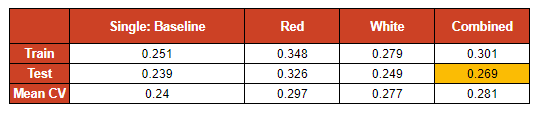

## **RandomForestClassifier**

Initally, applying simple RandomForestClassifier [random_state=0, max_depth = 3] with our split model we got:
* Train Cohen kappa score is: 0.28
* Test Cohen kappa score is: 0.224

This is slightly worse than the single model. We will implement each population best model, and the results are:
* Train Cohen kappa score is: 0.318
* Test Cohen kappa score is: 0.269

### **White Model**

In [ ]:
# WHITE MODEL
model_w = RandomForestClassifier(random_state=0, max_depth = 12, 
                                 class_weight={3:2, 4:2, 5:7, 6:6, 7:9, 8:4, 9:1})
model_w.fit(X_train_w, y_train_w)
y_train_w_pred = model_w.predict(X_train_w)
y_test_w_pred = model_w.predict(X_test_w)

# # CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_w, X_train_w, y_train_w, cv=cv, scoring=kappa_scorer)

# # # GridSearchCV
# my_params = {'max_depth': [5,8,12,15]}
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# clf = GridSearchCV(model_w, my_params, scoring=kappa_scorer, cv=cv)
# search = clf.fit(X_train, y_train)
# print(search.best_params_)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train_w, y_train_w_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test_w, y_test_w_pred):.3}')
cm_plot(confusion_matrix(y_test_w, y_test_w_pred), model_w)

### **Red Model**

In [ ]:
# RED MODEL
model_r = RandomForestClassifier (n_estimators=111, random_state=0, max_depth = 5)
model_r.fit(X_train_r, y_train_r)
y_train_r_pred = model_r.predict(X_train_r)
y_test_r_pred = model_r.predict(X_test_r)

# # CrossValidation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(model_r, X_train_r, y_train_r, cv=cv, scoring=kappa_scorer)

# # GridSearchCV
# my_params = {'bootstrap':[False,True], 'max_depth': [4,6,8,10,12]}
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# clf = GridSearchCV(model, my_params, scoring=kappa_scorer, cv=cv)
# search = clf.fit(X_train, y_train)
# print(search.best_params_)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train_r, y_train_r_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test_r, y_test_r_pred):.3}')
cm_plot(confusion_matrix(y_test_r, y_test_r_pred), model_r)

### **Combined**

In [ ]:
# RandomForestClassifier
model_r = RandomForestClassifier (n_estimators=111, random_state=0, max_depth = 5)
model_w = RandomForestClassifier(random_state=0, max_depth = 12, 
                                 class_weight={3:2, 4:2, 5:7, 6:6, 7:9, 8:4, 9:1})
model = run_estimator(model_r, model_w)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=kappa_scorer)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot_run_estimator(confusion_matrix(y_test, y_test_pred), model=model)

Up until now, we tried to find each population its best hyperparameters. In the combined method we used the red and white wines best hyperparameters to get a single result. We now try to use the best model we found for the whole data and inplement it as the white best hyperparameters. This model will be refered to as combined + single.

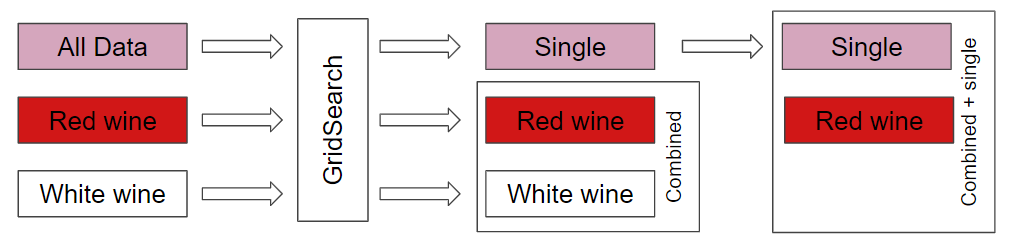

### **Combined: White = Best Single Model**

In [ ]:
# RandomForestClassifier
model_r = RandomForestClassifier (n_estimators=111, random_state=0, max_depth = 5)
model_w = RandomForestClassifier(random_state=0,
                            class_weight = {3:2, 4:2, 5:7, 6:6, 7:9, 8:4, 9:1},
                            max_depth=15, n_estimators = 200)
model = run_estimator(model_r, model_w)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=kappa_scorer)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot_run_estimator(confusion_matrix(y_test, y_test_pred), model=model)

In [ ]:
vals_r, vals_w = [],[]
for (val_r, col) in [*zip(model_r.feature_importances_,X_train.columns)]:
  vals_r.append(val_r)
for (val_w, col) in [*zip(model_w.feature_importances_,X_train.columns)]:
  vals_w.append(val_w)

fig, ax = plt.subplots(figsize=(12,4))
my_data_r = pd.Series(index=X_train.columns, data=vals_r)
my_data_w = pd.Series(index=X_train.columns, data=vals_w)
my_data=pd.concat([my_data_r,my_data_w], axis=1)
my_data.columns=['Red','White']
my_data.drop('type', inplace=True)
ax = my_data.plot(kind='bar', color=['r','w'],edgecolor='black',ax=ax)
plt.title('Feature Importances: Random Forest Combined Model')
plt.show()

This model use differently the features for red and white wines. 

Random Forest conclusions:
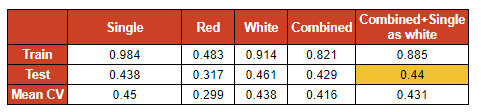

## **XGBoost**

Initally, applying simple XGBoost [random_state=0, max_depth = 3] with our split model we got:

* Train Cohen kappa score is: 0.528
* Test Cohen kappa score is: 0.286

This is slightly _______ than the single model. We will implement each population best model, and the results are:
* Train Cohen kappa score is: 0.686
* Test Cohen kappa score is: 0.387

### **White Model**

In [ ]:
# WHITE MODEL
model_w = XGBClassifier(random_state=0, max_depth=5, colsample_bytree=0.6,
                        reg_alpha=0.5)
model_w.fit(X_train_w, y_train_w)

y_train_w_pred = model_w.predict(X_train_w)
y_test_w_pred = model_w.predict(X_test_w)

# CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_w, X_train_w, y_train_w, cv=cv, scoring=kappa_scorer)

# # GridSearchCV
# my_params = {'colsample_bytree ': [3,4,5,6], 'gamma':[0,0.01,0.05]}
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# clf = GridSearchCV(model, my_params, scoring=kappa_scorer, cv=cv)
# search = clf.fit(X_train, y_train)
# print(search.best_params_)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train_w, y_train_w_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test_w, y_test_w_pred):.3}')
cm_plot(confusion_matrix(y_test_w, y_test_w_pred), model_w)

### **Red Model**

In [ ]:
# RED MODEL
model_r = XGBClassifier(random_state=0, max_depth=2, 
                        n_estimators=30, colsample_bytree=0.8,
                        subsample = 0.3)
                        
model_r.fit(X_train_r, y_train_r)
y_train_r_pred = model_r.predict(X_train_r)
y_test_r_pred = model_r.predict(X_test_r)
#objective='multi:softprob',           scale_pos_weight = 1)              eval_metric='mlogloss', learning_rate=0.05,

# # CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_r, X_train_r, y_train_r, cv=cv, scoring=kappa_scorer)

# GridSearchCV
# my_params = {'learning_rate':[0.05,0.1,0.2]}
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# clf = GridSearchCV(model, my_params, scoring=kappa_scorer, cv=cv)
# search = clf.fit(X_train, y_train)
# print(search.best_params_)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train_r, y_train_r_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test_r, y_test_r_pred):.3}')
cm_plot(confusion_matrix(y_test_r, y_test_r_pred), model_r)

### **Combined**

In [ ]:
# XGBoost
model_r = XGBClassifier(random_state=0, max_depth=2, 
                        n_estimators=30, colsample_bytree=0.8,
                        subsample = 0.3)
model_w = XGBClassifier(random_state=0, max_depth=5, colsample_bytree=0.6,
                        reg_alpha=0.5)

model = run_estimator(model_r, model_w)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=kappa_scorer)

# Print the results
print('CV:', scores)
print('CV mean:', scores.mean())
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot_run_estimator(confusion_matrix(y_test, y_test_pred), model=model)

### **Combined: White = Best Single Model**

In [ ]:
model_r = XGBClassifier(random_state=0, max_depth=2, 
                        n_estimators=30, colsample_bytree=0.8,
                        subsample = 0.3)
model_w = XGBClassifier(alpha=1, colsample_bytree=0.9,
                    max_depth=10, n_extimator=100,
                    objective='multi:softmax')

model = run_estimator(model_r, model_w)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# CrossValidation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=kappa_scorer)

# Print the results
print('CV:', scores)
print('CV mean:', scores.mean())
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm_plot_run_estimator(confusion_matrix(y_test, y_test_pred), model=model)

In [ ]:
vals_r, vals_w = [],[]
for (val_r, col) in [*zip(model_r.feature_importances_,X_train.columns)]:
  vals_r.append(val_r)
for (val_w, col) in [*zip(model_w.feature_importances_,X_train.columns)]:
  vals_w.append(val_w)

fig, ax = plt.subplots(figsize=(15,6))
my_data_r = pd.Series(index=X_train.columns, data=vals_r)
my_data_w = pd.Series(index=X_train.columns, data=vals_w)
my_data=pd.concat([my_data_r,my_data_w], axis=1)
my_data.columns=['Red','White']
my_data.drop('type', inplace=True)
ax = my_data.plot(kind='bar', color=['r','w'],edgecolor='black',ax=ax)
plt.title('Feature Importances: XGBoost Combined Model')
plt.show()

XGBoost conclusions:
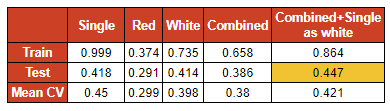

## **VotingClassifier**

In [ ]:
classifiers = [('LR', LogisticRegression(multi_class='ovr', random_state=42)),
               ('DTC', DecisionTreeClassifier(max_depth=5, random_state=42)),
               ('SVC', SVC(probability=True, random_state=42))]

### **White Model**

In [ ]:
# WHITE MODEL
model_w = VotingClassifier(estimators=classifiers, voting='soft')
model_w.set_params(LR__C=1)
model_w.fit(X_train_w, y_train_w)
y_train_w_pred = model_w.predict(X_train_w)
y_test_w_pred = model_w.predict(X_test_w)

# CrossValidation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(model_w, X_train_w, y_train_w, cv=cv, scoring=kappa_scorer)

# GridSearchCV
# my_params = [{'LR__C':[0.1,1,3], 'DTC__max_depth':[4,5,6], 
#                'LR__class_weight': [{3:2, 4:5, 5:6, 6:6, 7:8, 8:4, 9:1}],
#               'LR__penalty': ['l2']}]
# clf = GridSearchCV(model_w, my_params, cv=5, scoring=kappa_scorer)
# search = clf.fit(X_train, y_train)
# print("Best parameters:", clf.best_params_)

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train_w, y_train_w_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test_w, y_test_w_pred):.3}')
cm_plot(confusion_matrix(y_test_w, y_test_w_pred), model_w)

### **Red Model**

In [ ]:
# RED MODEL
model_r = VotingClassifier(estimators=classifiers, voting='soft')
model_r.set_params(LR__C=2.5)
model_r.fit(X_train_r, y_train_r)
y_train_r_pred = model_r.predict(X_train_r)
y_test_r_pred = model_r.predict(X_test_r)

# # CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model_r, X_train_r, y_train_r, cv=cv, scoring=kappa_scorer)

# GridSearchCV
# my_params = {}
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# clf = GridSearchCV(model, my_params, scoring=kappa_scorer, cv=cv)
# search = clf.fit(X_train, y_train)
# search.best_params_

# Print the results
print('CV:', scores)
print('CV Mean:', scores.mean().round(3))
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train_r, y_train_r_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test_r, y_test_r_pred):.3}')
cm_plot(confusion_matrix(y_test_r, y_test_r_pred), model_r)

### **Combined**

In [ ]:
# Voting Classifier
model_r = VotingClassifier(estimators=classifiers, voting='soft')
model_r.set_params(LR__C=2.5)
model_w = VotingClassifier(estimators=classifiers, voting='soft')
model_w.set_params(LR__C=1)
model = run_estimator(model_r, model_w)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=kappa_scorer)

# Print the results
print('CV:', scores)
print('CV mean:', scores.mean())
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm = confusion_matrix(y_test, y_test_pred)
cm_plot_run_estimator(cm, model=model)

### **Combined: White = Best Single Model**

In [ ]:
# Voting Classifier
model_r = VotingClassifier(estimators=classifiers, voting='soft')
model_r.set_params(LR__C=2.5)
model_w = VotingClassifier(estimators=classifiers, voting='soft')
model_w.set_params(DTC__max_depth=12,LR__multi_class='auto')

model = run_estimator(model_r, model_w)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# CrossValidation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=kappa_scorer)

# Print the results
print('CV:', scores)
print('CV mean:', scores.mean())
print(f'Train Cohen kappa score is: {cohen_kappa_score(y_train, y_train_pred):.3}')
print(f'Test Cohen kappa score is: {cohen_kappa_score(y_test, y_test_pred):.3}')
cm = confusion_matrix(y_test, y_test_pred)
cm_plot_run_estimator(cm, model=model)

Voting Classifier results:
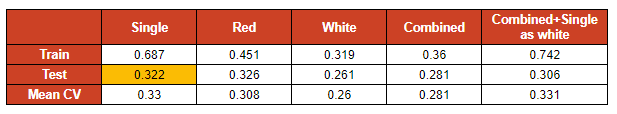

# **Conclusions**

* Combined data failed to improve model scores
* Nevertheless, splitting the data into 2 populations was worth the effort, except for in the VotingClassifier model
* Applying grid search on each population and joined data seperately, gave added value

Further options to explore the data are:
* Oversampling \ undersampling should be executed on the split model
* Combining 2 different models (instead of one model with different hyper-parameters)
* More time to GridSearch and improve the scores  ;-)
* Binning the quality target into good, medium and bad
* Predicting wine type 

